In [78]:
model_name = './gpt2' #"gpt2"

In [79]:
import torch

device = torch.device("cuda")

In [80]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt

--2024-04-15 16:01:10--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt [following]
--2024-04-15 16:01:11--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9624463 (9.2M) [text/plain]
Saving to: ‘train.txt.19’

train.txt.19        100%[===================>]   9.18M  3.26MB/s    in 2.8s    

2024-04-15 16:01:14 (3.26 MB/s) - ‘train.txt.19’ saved [9624463/9624463]



In [81]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt

--2024-04-15 16:01:15--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt [following]
--2024-04-15 16:01:15--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1351149 (1.3M) [text/plain]
Saving to: ‘test.txt.19’

test.txt.19         100%[===================>]   1.29M  2.71MB/s    in 0.5s    

2024-04-15 16:01:16 (2.71 MB/s) - ‘test.txt.19’ saved [1351149/1351149]



In [82]:
!head -n 5 train.txt

name : The Vaults | Type : pub | price : more than £ 30 | customer rating : 5 out of 5 | near : Café Adriatic||The Vaults pub near Café Adriatic has a 5 star rating . Prices start at £ 30 . 
name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Café Brazil||Close to Café Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £ 10.50 . Delicious Pub food . 
name : The Eagle | Type : coffee shop | food : Japanese | price : less than £ 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King||The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £ 20 for Japanese food . 
name : The Mill | Type : coffee shop | food : French | price : £ 20 - 25 | area : riverside | near : The Sorrento||Located near The Sorrento is a French Theme eatery and coffee shop called The Mill , with a price range at £ 20- £ 25 it is in the riverside area . 
name : Loch 

Convert above data into JsonL format.

In [83]:
import sys
import io
import json

def format_convert(read_file, write_file):
    with open(read_file, "r", encoding="utf8") as reader, \
    	 open(write_file, "w", encoding="utf8") as writer :
    	for line in reader:
    		items = line.strip().split("||")
    		context = items[0]
    		completion = items[1].strip("\n")
    		x = {}
    		x["context"] = context
    		x["completion"] = completion
    		writer.write(json.dumps(x)+"\n")

format_convert("train.txt", "train_formatted.jsonl")
format_convert("test.txt", "test_formatted.jsonl")

Show the converted data (first 5 rows).

In [84]:
with open("train_formatted.jsonl", "r") as reader:
    for _ in range(5):
        print(next(reader))

{"context": "name : The Vaults | Type : pub | price : more than \u00a3 30 | customer rating : 5 out of 5 | near : Caf\u00e9 Adriatic", "completion": "The Vaults pub near Caf\u00e9 Adriatic has a 5 star rating . Prices start at \u00a3 30 ."}

{"context": "name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Caf\u00e9 Brazil", "completion": "Close to Caf\u00e9 Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of \u00a3 10.50 . Delicious Pub food ."}

{"context": "name : The Eagle | Type : coffee shop | food : Japanese | price : less than \u00a3 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King", "completion": "The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than \u00a3 20 for Japanese food ."}

{"context": "name : The Mill | Type : coffee shop | food : French | price : \u00a3 20 - 25 | area : riverside | near : The Sorrento", "com

In [85]:


from transformers import AutoTokenizer
import os

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    fast_tokenizer=True)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [86]:
block_size = 512

print(f"Max length of tokens is {tokenizer.model_max_length} in this model.")
print(f"But here we use max {block_size} tokens in the training.")

Max length of tokens is 1024 in this model.
But here we use max 512 tokens in the training.


In [87]:
from torch.utils.data import DataLoader
import pandas as pd

def fill_ignore_label(l, c):
    l[:len(c) - 1] = [-100] * (len(c) - 1)
    return l

def pad_tokens(tokens, max_seq_length, padding_token):
    res_tokens = tokens[:max_seq_length]
    token_len = len(res_tokens)
    res_tokens = res_tokens + \
        [padding_token for _ in range(max_seq_length - token_len)]
    return res_tokens

def collate_batch(batch):
    # tokenize both context and completion respectively
    # (context and completion is delimited by "\n")
    context_list = list(zip(*batch))[0]
    context_list = [c + "\n" for c in context_list]
    completion_list = list(zip(*batch))[1]
    context_result = tokenizer(context_list)
    context_tokens = context_result["input_ids"]
    context_masks = context_result["attention_mask"]
    completion_result = tokenizer(completion_list)
    completion_tokens = completion_result["input_ids"]
    completion_masks = completion_result["attention_mask"]
    # concatenate token
    inputs = [i + j for i, j in zip(context_tokens, completion_tokens)]
    masks = [i + j for i, j in zip(context_masks, completion_masks)]
    # create label
    eos_id = tokenizer.encode(tokenizer.eos_token)[0]
    labels = [t[1:] + [eos_id] for t in inputs]
    labels = list(map(fill_ignore_label, labels, context_tokens))
    # truncate and pad tokens
    inputs = [pad_tokens(t, block_size, 0) for t in inputs] # OPT and GPT-2 doesn't use pad token (instead attn mask is used)
    masks = [pad_tokens(t, block_size, 0) for t in masks]
    labels = [pad_tokens(t, block_size, -100) for t in labels]
    # convert to tensor
    inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
    masks = torch.tensor(masks, dtype=torch.int64).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    # print(labels.shape)
    return inputs, labels, masks


Now create PyTorch dataloader with previous function (collator function).

> Note : In this example, data is small and we then load all JSON data in memory.<br>
> When it's large, load data progressively by implementing custom PyTorch dataset. (See [here](https://github.com/tsmatz/decision-transformer) for example.)

In [88]:
batch_size = 8
gradient_accumulation_steps = 16

data = pd.read_json("train_formatted.jsonl", lines=True)
dataloader = DataLoader(
    list(zip(data["context"], data["completion"])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

## Load model

Load model from Hugging Face.

In [89]:
from transformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
).to(device)

# num_hidden_layers = config.n_layer
# parameters_to_finetuned = []
# for name, param in model.named_parameters():
#     if 'h.' + str(num_hidden_layers - 2) in name or 'h.' + str(num_hidden_layers - 1) in name:
#         parameters_to_finetuned.append(param)

In [90]:
def generate_text(model, input, mask, eos_id, pred_sequence_length):
    predicted_last_id = -1
    start_token_len = torch.sum(mask).cpu().numpy()
    token_len = start_token_len
    with torch.no_grad():
        while (predicted_last_id != eos_id) and \
              (token_len - start_token_len < pred_sequence_length):
            output = model(
                input_ids=input,
                attention_mask=mask,
            )
            predicted_ids = torch.argmax(output.logits, axis=-1).cpu().numpy()
            predicted_last_id = predicted_ids[0][token_len - 1]
            input[0][token_len] = predicted_last_id
            mask[0][token_len] = 1
            token_len = torch.sum(mask).cpu().numpy()
    return input, token_len

In [91]:
eos_id = tokenizer.encode(tokenizer.eos_token)[0]

result = tokenizer("Once upon a time,")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

result = tokenizer("My name is Clara and I am")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

Once upon a time, the world was a place of great beauty and great danger. The world was
My name is Clara and I am a woman. I am a woman who is a woman. I am a


In [92]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("********** input **********")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("********** result **********")
    print(tokenizer.decode(result_token[0][:result_len]))

********** input **********
name : The Cricketers | Type : restaurant | food : Chinese | price : moderate | customer rating : 1 out of 5 | area : riverside | family friendly : no | near : All Bar One

********** result **********
name : The Cricketers | Type : restaurant | food : Chinese | price : moderate | customer rating : 1 out of 5 | area : riverside | family friendly : no | near : All Bar One

The Cricketers | Type : restaurant | food : Chinese | price : moderate | customer rating : 1 out of 5 | area : riverside
********** input **********
name : The Wrestlers | Type : restaurant | food : Japanese | price : more than £ 30 | area : city centre | family friendly : no | near : Raja Indian Cuisine

********** result **********
name : The Wrestlers | Type : restaurant | food : Japanese | price : more than £ 30 | area : city centre | family friendly : no | near : Raja Indian Cuisine

The restaurant is located in the centre of the city centre. It is a small restaurant with a small menu.

In [93]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [94]:
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType
from peft import PeftModel



In [95]:
import math
from torch import nn

class LoRA_Linear(nn.Module):
    def __init__(self, weight, bias, lora_dim): #lora_dim = r = 4?
        super(LoRA_Linear, self).__init__()

        row, column = weight.shape
        # row, column = weight.size(0)

        # restore Linear
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight": weight})
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight": weight, "bias": bias}) #self.weight = orginal weights

        # create LoRA weights (with initialization)
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_uniform_(self.lora_right, a=math.sqrt(5))
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))


    # input.shape == [8, 512, 768] batch_size, latent_dim, embedding_size
    def forward(self, input):
        print("input shape:", input.shape)
        print(self.linear)
        x = self.linear(input)
        print(x.shape)
        print(self.lora_right.shape)
        print(self.lora_left.shape)
        assert 1==0
        y = input @ self.lora_right @ self.lora_left
        print('output:',(x+y).shape)
        assert 1==0
        return x + y
    


In [ ]:
import math
from torch import nn

class LoRA_Linear(nn.Module):
    def __init__(self, weight, bias, lora_dim): #lora_dim = r = 4?
        super(LoRA_Linear, self).__init__()

        row, column = weight.shape
        # row, column = weight.size(0)

        # restore Linear
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight": weight})
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight": weight, "bias": bias}) #self.weight = orginal weights

        # create LoRA weights (with initialization)
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_uniform_(self.lora_right, a=math.sqrt(5))
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))


    # input.shape == [8, 512, 768] batch_size, latent_dim, embedding_size
    def forward(self, input):
        print("input shape:", input.shape)
        print(self.linear)
        x = self.linear(input)
        print(x.shape)
        print(self.lora_right.shape)
        print(self.lora_left.shape)
        assert 1==0
        y = input @ self.lora_right @ self.lora_left
        print('output:',(x+y).shape)
        assert 1==0
        return x + y
    


In [96]:
lora_dim = 128

# get target module name
target_names = []
target_modules = []
# layer_tobe_finetuned = model.
for name, module in model.named_modules():
    # print(name)
    if "transformer.h.10" in name or "transformer.h.11" in name:
        if "ln_1" in name or "ln_2" in name: # or "attn.c" in name or "mlp.c" in name:
            target_names.append(name)
            target_modules.append(module)


# replace each module with LoRA
for name in target_names:
    name_struct = name.split(".")
    # get target module
    module_list = [model]
   
    for struct in name_struct:
        module_list.append(getattr(module_list[-1], struct))

    # build LoRA
    lora = LoRA_Linear(
        weight = torch.transpose(module_list[-1].weight.unsqueeze(0), 0, 1),
        bias = module_list[-1].bias,
        lora_dim = lora_dim,
    ).to(device)
    # replace
    module_list[-2].__setattr__(name_struct[-1], lora)

In [97]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-9): 10 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (10-11): 2 x GPT2Block(
        (ln_1): LoRA_Linear(
          (linear): Linear(in_features=1, out_features=768, bias=True)
        )
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropo

Finally, freeze all parameters except for LoRA parameters.

In [98]:
for name, param in model.named_parameters():
    if "lora_right" in name or "lora_left" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        

## Fine-tune

In [100]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=0.0002,
    betas=(0.9, 0.999),
    eps=1e-6,
)

# from came_pytorch import CAME
# optimizer = CAME(
#     model.parameters(),
#     lr=2e-4,
#     weight_decay=1e-2,
#     betas=(0.9, 0.999, 0.9999),
#     eps=(1e-30, 1e-16)
# )

# from adafactor import AdaFactor

# from adafactor1 import Adafactor
# optimizer = Adafactor(model.parameters()) $try lr = 1e-3

In [101]:
from torch.optim.lr_scheduler import LambdaLR, LRScheduler, ExponentialLR, CosineAnnealingLR

num_epochs = 2
num_warmup_steps = 500

num_update_steps = math.ceil(len(dataloader) / batch_size / gradient_accumulation_steps)
def _get_linear_schedule(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_update_steps * num_epochs - current_step) / float(max(1, num_update_steps * num_epochs - num_warmup_steps)))

# scheduler = LambdaLR(optimizer, lr_lambda=_get_linear_schedule)

scheduler = CosineAnnealingLR(optimizer, T_max= 32)

In [1]:
import pickle
def save_matrix(self, matrix):
    file_name = './save/' + '.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(matrix, file)


Run fine-tuning.

In [102]:
from torch.nn import functional as F

if os.path.exists("loss.txt"):
    os.remove("loss.txt")

for epoch in range(num_epochs):
    optimizer.zero_grad()
    model.train()
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
           
           
            outputs = model(
                input_ids=inputs,
                attention_mask=masks,
            )
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            print(f"Epoch {epoch+1} {math.ceil((i + 1) / batch_size / gradient_accumulation_steps)}/{num_update_steps} - loss: {loss.item() :2.4f}", end="\r")

        # record loss
        with open("loss.txt", "a") as f:
            f.write(str(loss.item()))
            f.write("\n")
    print("")

# save model
torch.save(model.state_dict(), "finetuned_gpt2.bin")

input shape: torch.Size([8, 512, 768])
Linear(in_features=1, out_features=768, bias=True)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x768 and 1x768)

> Note : Here we save LoRA-enabled model without any changes, but you can also merge the trained LoRA's parameters into the original model's weights.

Show loss transition in plot.

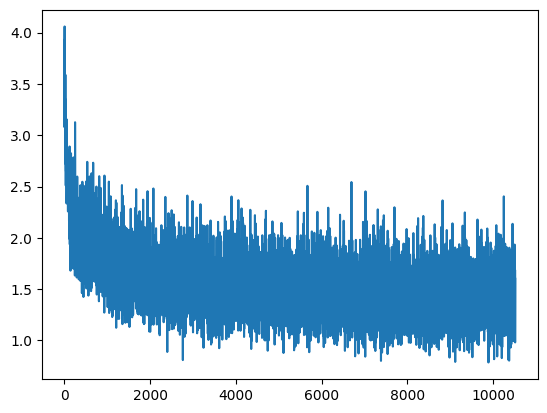

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("loss.txt")
plt.plot(data)
plt.show()

In [ ]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("********** input **********")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("********** result **********")
    print(tokenizer.decode(result_token[0][:result_len]))

********** input **********
name : The Mill | Type : restaurant | food : English | price : less than £ 20 | area : city centre | family friendly : yes | near : Raja Indian Cuisine

********** result **********
name : The Mill | Type : restaurant | food : English | price : less than £ 20 | area : city centre | family friendly : yes | near : Raja Indian Cuisine
The Mill is a family - friendly restaurant that serves English food. It is located in the city centre near Raja Indian Cuisine.<|endoftext|>
********** input **********
name : The Punter | Type : restaurant | food : Indian | price : high | customer rating : 1 out of 5 | area : riverside | family friendly : no | near : Express by Holiday Inn

********** result **********
name : The Punter | Type : restaurant | food : Indian | price : high | customer rating : 1 out of 5 | area : riverside | family friendly : no | near : Express by Holiday Inn
The Punter is a restaurant providing Indian food in the high price range. It is located in 